**Sistem Prediksi Stroke**

Dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

# **Data Loading**

Impor library dan memuat dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os
import joblib
from google.colab import files
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzanbyu","key":"6315917ff5833a191af787ea7c399e2b"}'}

In [4]:
# Memuat dataset
!mkdir StrokePrediction
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset -p /content/StrokePrediction/

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 51.4MB/s]


In [5]:
!unzip '/content/StrokePrediction/stroke-prediction-dataset.zip' -d /content/StrokePrediction/

Archive:  /content/StrokePrediction/stroke-prediction-dataset.zip
  inflating: /content/StrokePrediction/healthcare-dataset-stroke-data.csv  


In [6]:
# Memuat dan menampilkan dataframe
csv_loc = '/content/StrokePrediction/healthcare-dataset-stroke-data.csv'
stroke_data = pd.read_csv(csv_loc)

stroke_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Dari output diatas, didapatkan informasi terdapat 5.110 records dan 12 kolom atau fitur yaitu: 'id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', dan 'stroke'. Fitur 'id' tidak akan digunakan dalam pengembangan sistem prediksi, maka akan dihapus pada tahap Data Preparation. Selain itu, terdapat missing value berupa nilai NaN pada fitur 'bmi', maka hal ini akan ditangani pada tahap EDA - Menangani Missing Value.

# **EDA - Deskripsi Variabel**

Berdasarkan informasi dari penyedia dataset [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), atribut pada dataset adalah sebagai berikut:

- id: Unique Identifier
- gender: Jenis kelamin pasien (Male, Female, Other)
- age: Usia pasien
- hypertension: Nilai "0" menunjukkan pasien tidak memiliki tekanan darah tinggi, nilai "1" menunjukkan pasien memiliki tekanan darah tinggi.
- heart_disease: Nilai "0" menunjukkan pasien tidak memiliki penyakit jantung, nilai "1" menunjukkan pasien memiliki penyakit jantung.
- ever_married: Status menikah yang ditunjukkan dengan nilai "Yes" dan "No".
- work_type: Jenis pekerjaan yang ditunjukkan dengan; masih anak-anak (children), PNS (Govt_jov), Tidak pernah bekerja (Never_worked), swasta (Private), dan wiraswasta (Self-employed).
- Residence_type: Lingkungan tempat tinggal apakah di pedesaan (Rural) atau di perkotaan (Urban).
- avg_glucose_level: Kadar glukosa rata-rata dalam darah.
- bmi: Indeks massa tubuh atau ukuran berat badan pasien.
- smoking_status: Status merokok pasien, apakah dahulu merupakan seorang perokok (formerly smoked), tidak pernah merokok (never smoked), saat ini seorang perokok (smokes), atau tidak diketahui (unknown).
- stroke: Nilai "0" menunjukkan pasien tidak memiliki resiko stroke, nilai "1" menunjukkan pasien memiliki resiko stroke.

In [7]:
# Mengecek informasi pada dataset
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Dari output diatas dapat diketahui bahwa:
-	Terdapat 4 fitur numerik dengan tipe int64, yaitu: 'id', 'hypertension', 'heart_disease', dan 'stroke'. 4 fitur ini nantinya akan masuk kedalam categorical features karena hanya memiliki dua nilai yaitu True dan False.
-	Terdapat 3 fitur numerik dengan tipe data float64, yaitu: 'age', 'avg_glucose_level', dan 'bmi'.
- Terdapat 5 fitur dengan tipe object, yaitu: 'gender', 'ever_married', 'work_type', 'Residence_type', dan 'smoking_status'. fitur-fitur ini merupakan categorical features (fitur non-numerik).

In [8]:
# Melihat deskripsi statistik data
stroke_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- Count adalah jumlah sampel pada data.
- Mean adalah nilai rata-rata.
- Std adalah standar deviasi.
- Min yaitu nilai minimum setiap kolom.
- 25% adalah kuartil pertama. Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
- 50% adalah kuartil kedua, atau biasa juga disebut median (nilai tengah).
- 75% adalah kuartil ketiga.
- Max adalah nilai maksimum.

# **EDA - Menangani Missing Value dan Outliers**

Menangani missing value pada fitur BMI.

In [9]:
# Mengecek missing value pada dataset
stroke_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Diketahui terdapat 201 missing value pada fitur 'bmi'. Dikarenakan data yang terbatas (5.110 records), alih-alih melakukan drop pada missing value, hal ini akan diatasi dengan mengganti nilai missing value dengan nilai mean (rata-rata) berat badan 'bmi' untuk mempertahankan distribusi data.

In [10]:
# Missing value pada fitur 'bmi' akan diganti dengan nilai rata-rata berat badan
stroke_data['bmi'].fillna(stroke_data['bmi'].mean(), inplace=True)

stroke_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


Melakukan visualisasi boxplot untuk melihat outliers pada masing-masing fitur numerik.

**- Fitur Usia**

<Axes: xlabel='age'>

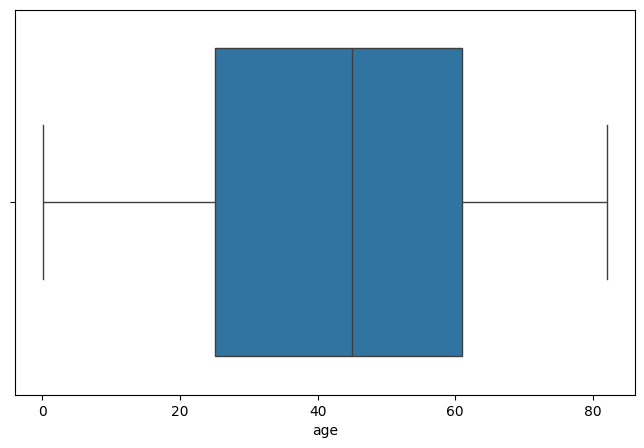

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=stroke_data['age'])

**- Fitur Kadar Glukosa Rata-rata**

<Axes: xlabel='avg_glucose_level'>

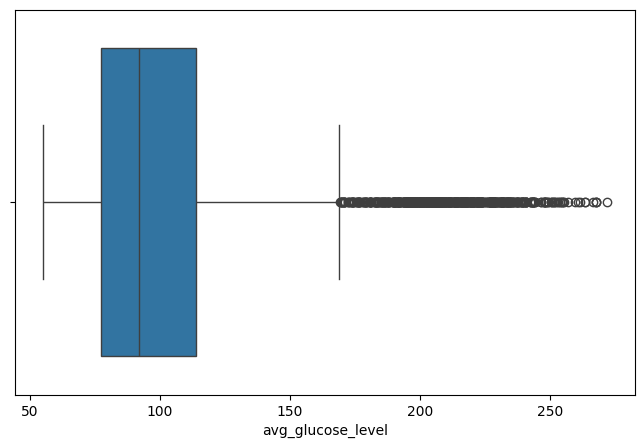

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=stroke_data['avg_glucose_level'])

**- Fitur BMI**

<Axes: xlabel='bmi'>

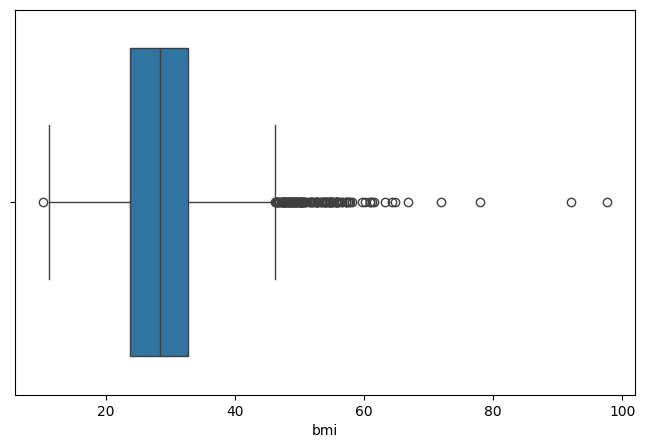

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=stroke_data['bmi'])

Diketahui dari visualisasi outliers diatas, terdapat outliers pada fitur BMI, sehingga dalam menangani outliers tersebut digunakan metode IQR dengan membuat batas bawah dan batas atas dengan persamaan:

Batas bawah = Q1 - 1.5 * IQR

Batas atas = Q3 + 1.5 * IQR

In [14]:
# Menangani outliers pada fitur 'bmi'
feature_outliers = ['bmi']

Q1 = stroke_data[feature_outliers].quantile(0.25)
Q3 = stroke_data[feature_outliers].quantile(0.75)
IQR=Q3 - Q1

stroke_data[feature_outliers]=stroke_data[feature_outliers][~((stroke_data[feature_outliers] < (Q1 - 1.5 * IQR))|(stroke_data[feature_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Cek ukuran dataset setelah drop outliers
stroke_data.shape

(5110, 12)

Melihat hasil penanganan outliers pada fitur BMI.

<Axes: xlabel='bmi'>

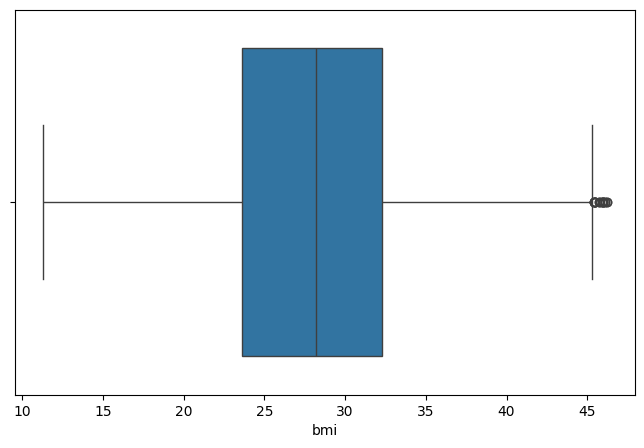

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=stroke_data['bmi'])

# **EDA - Univariate Analysis**

Langkah selanjutnya membagi fitur pada dataset menjadi numerical features dan categorical features.

In [16]:
categoric_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
numeric_features = ['age', 'avg_glucose_level', 'bmi']

## **Categorical Features**
Melakukan analisis terhadap masing-masing fitur kategori.

**- Fitur Jenis Kelamin**

        Jumlah Sampel  Persentase
Female           2994        58.6
Male             2115        41.4
Other               1         0.0


Text(0.5, 1.0, 'gender')

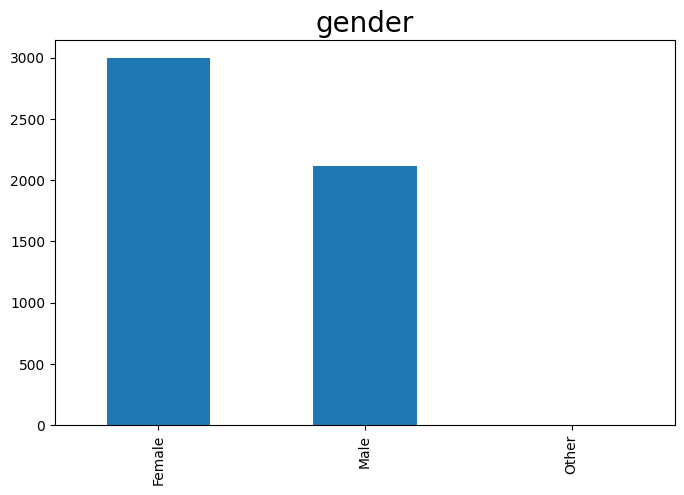

In [17]:
# Memvisualisasikan categorical features 'gender'
plt.figure(figsize=(8, 5))
feature = categoric_features[0]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Dari visualisasi fitur Jenis Kelamin diatas terdapat 3 kategori pada fitur jenis kelamin, secara berurutan dari yang paling banyak yaitu: Female, Male, dan Other. Dari data persentase dapat disimpulkan bahwa lebih dari 50% sampel merupakan perempuan (Female).

In [18]:
# Mengecek jumlah sample pada masing-masing variabel pada fitur 'gender'
stroke_data.groupby('gender').agg('count')

,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,,
Female,2994,2994,2994,2994,2994,2994,2994,2994,2895,2994,2994
Male,2115,2115,2115,2115,2115,2115,2115,2115,2088,2115,2115
Other,1,1,1,1,1,1,1,1,1,1,1


Diketahui terdapat sample yang terlalu sedikit pada jenis kelamin 'Other' di fitur 'gender'. Maka nantinya akan dilakukan penghapusan terhadap sample 'Other' pada tahap Data Preparation.

**- Fitur Tekanan Darah Tinggi**

   Jumlah Sampel  Persentase
0           4612        90.3
1            498         9.7


Text(0.5, 1.0, 'hypertension')

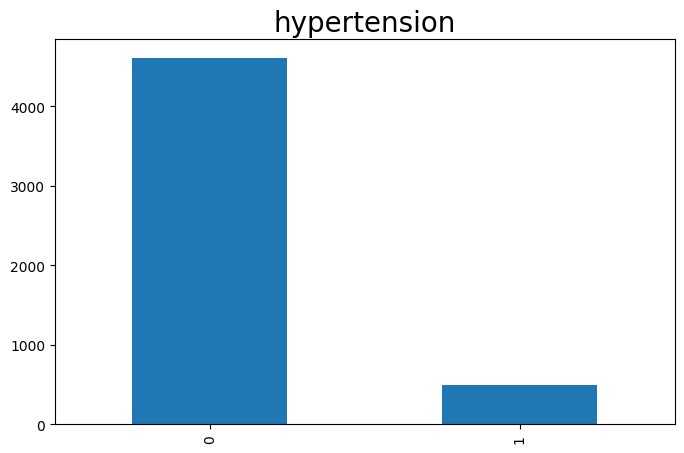

In [19]:
# Memvisualisasikan categorical features 'hypertension'
plt.figure(figsize=(8, 5))
feature = categoric_features[1]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Dari visualisasi fitur Tekanan Darah Tinggi diatas, terdapat lebih dari 90% merupakan sampel pasien yang tidak memiliki tekanan darah tinggi ditunjukkan dengan label angka "0".

**- Fitur Penyakit Jantung**

   Jumlah Sampel  Persentase
0           4834        94.6
1            276         5.4


Text(0.5, 1.0, 'heart_disease')

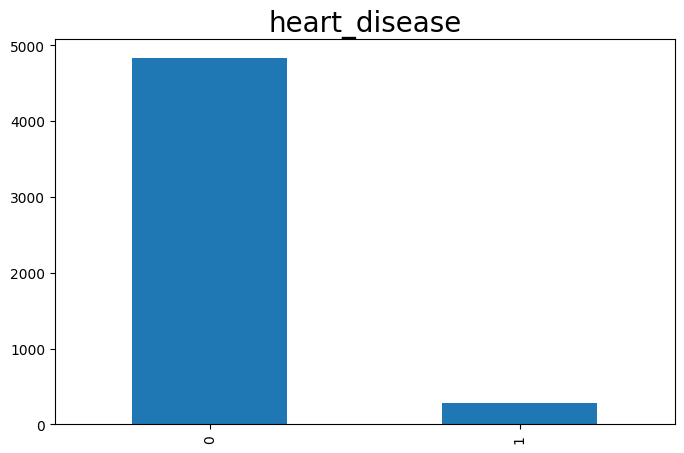

In [20]:
# Memvisualisasikan categorical features 'heart_disease'
plt.figure(figsize=(8, 5))
feature = categoric_features[2]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Dari visualisasi fitur Penyakit Jantung diatas, terdapat lebih dari 94% merupakan sampel pasien yang tidak memiliki penyakit jantung ditunjukkan dengan label angka "0".

**- Fitur Status Menikah**

     Jumlah Sampel  Persentase
Yes           3353        65.6
No            1757        34.4


Text(0.5, 1.0, 'ever_married')

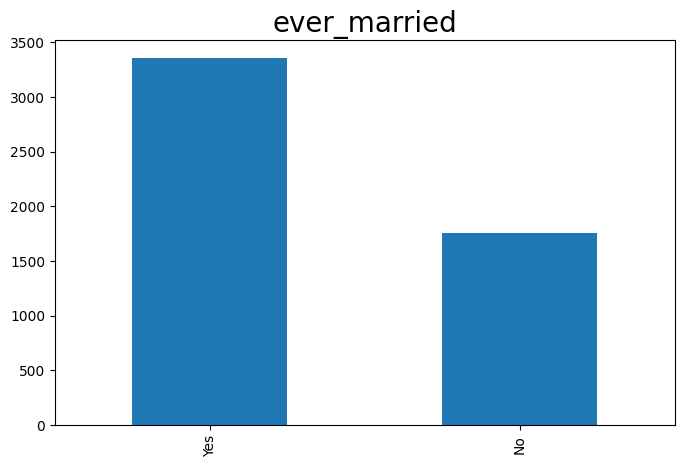

In [21]:
# Memvisualisasikan categorical features 'ever_married'
plt.figure(figsize=(8, 5))
feature = categoric_features[3]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Dari visualisasi fitur Status Menikah diatas, terdapat lebih dari 65% merupakan sampel pasien dalam status sudah menikah ditunjukkan dengan label "Yes".

**- Fitur Jenis Pekerjaan**

               Jumlah Sampel  Persentase
Private                 2925        57.2
Self-employed            819        16.0
children                 687        13.4
Govt_job                 657        12.9
Never_worked              22         0.4


Text(0.5, 1.0, 'work_type')

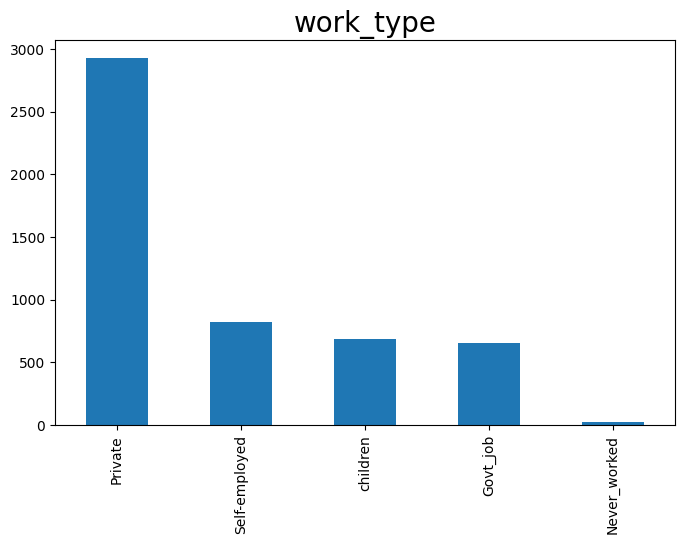

In [22]:
# Memvisualisasikan categorical features 'work_type'
plt.figure(figsize=(8, 5))
feature = categoric_features[4]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Dari visualisasi fitur Jenis Pekerjaan diatas terdapat 5 kategori pada fitur jenis pekerjaan, secara berurutan dari yang paling banyak yaitu: Swasta, Wiraswasta, masih anak-anak, PNS, dan belum bekerja. Dari data persentase dapat disimpulkan bahwa lebih dari 57% merupakan sampel pasien yang sudah bekerja di Swasta.

**- Fitur Lingkungan Tempat Tinggal**

       Jumlah Sampel  Persentase
Urban           2596        50.8
Rural           2514        49.2


Text(0.5, 1.0, 'Residence_type')

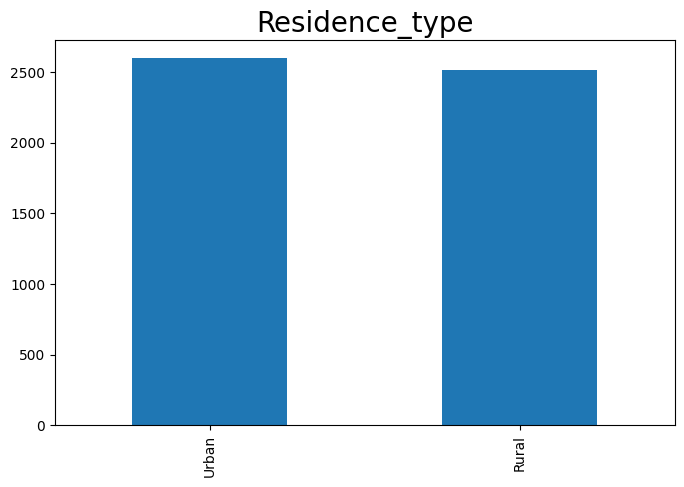

In [23]:
# Memvisualisasikan categorical features 'Residence_type'
plt.figure(figsize=(8, 5))
feature = categoric_features[5]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Dari visualisasi fitur Lingkungan Tempat Tinggal diatas, sampel data cukup seimbang ditunjukkan persentase dari yang paling dominan yaitu, perkotaan (Urban) sebanyak 50.8%, dan pedesaan (Rural) sebanyak 49.2%.

**- Fitur Status Merokok**

                 Jumlah Sampel  Persentase
never smoked              1892        37.0
Unknown                   1544        30.2
formerly smoked            885        17.3
smokes                     789        15.4


Text(0.5, 1.0, 'smoking_status')

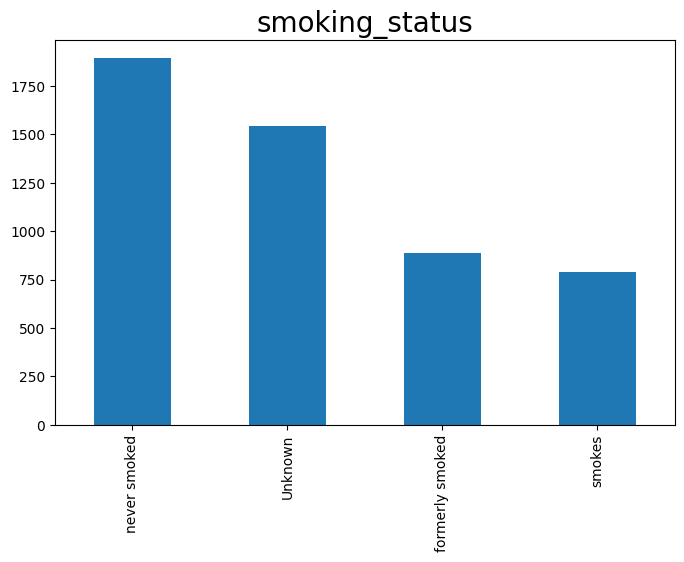

In [24]:
# Memvisualisasikan categorical features 'smoking_status'
plt.figure(figsize=(8, 5))
feature = categoric_features[6]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Dari visualisasi fitur Status Merokok diatas, terdapat 4 kategori secara berurutan mulai dari yang terbanyak yaitu, tidak pernah merokok, tidak diketahui, dahulu pernah merokok, dan perokok. Sebanyak 37% sampel merupakan pasien yang tidak pernah merokok.

**- Fitur Stroke**

   Jumlah Sampel  Persentase
0           4861        95.1
1            249         4.9


Text(0.5, 1.0, 'stroke')

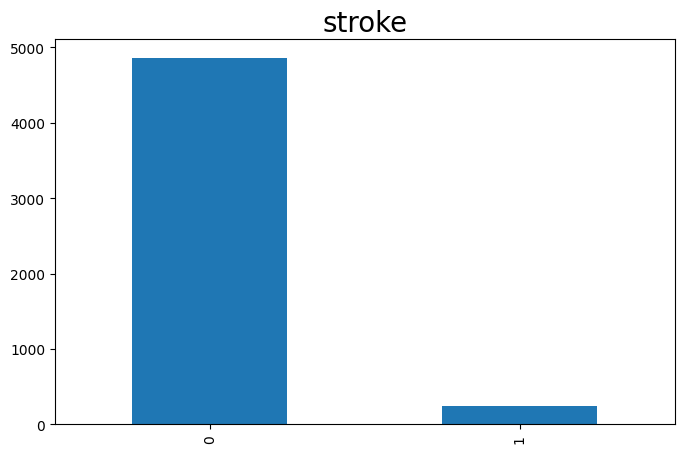

In [25]:
# Memvisualisasikan categorical features 'stroke'
plt.figure(figsize=(8, 5))
feature = categoric_features[7]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Diketahui pada fitur Stroke dapat dikatakan memiliki data yang tidak seimbang, hal ini dapat dilihat perbedaan sampel yang sangat signifikan antara sampel pasien yang tidak memiliki resiko stroke (0), dan sampel pasien yang memiliki resiko stroke (1). Fitur Stroke merupakan fitur target pada proyek ini, maka ketidakseimbangan data pada fitur target ini akan ditangani pada tahap Data Preparation.

## **Numerical Features**

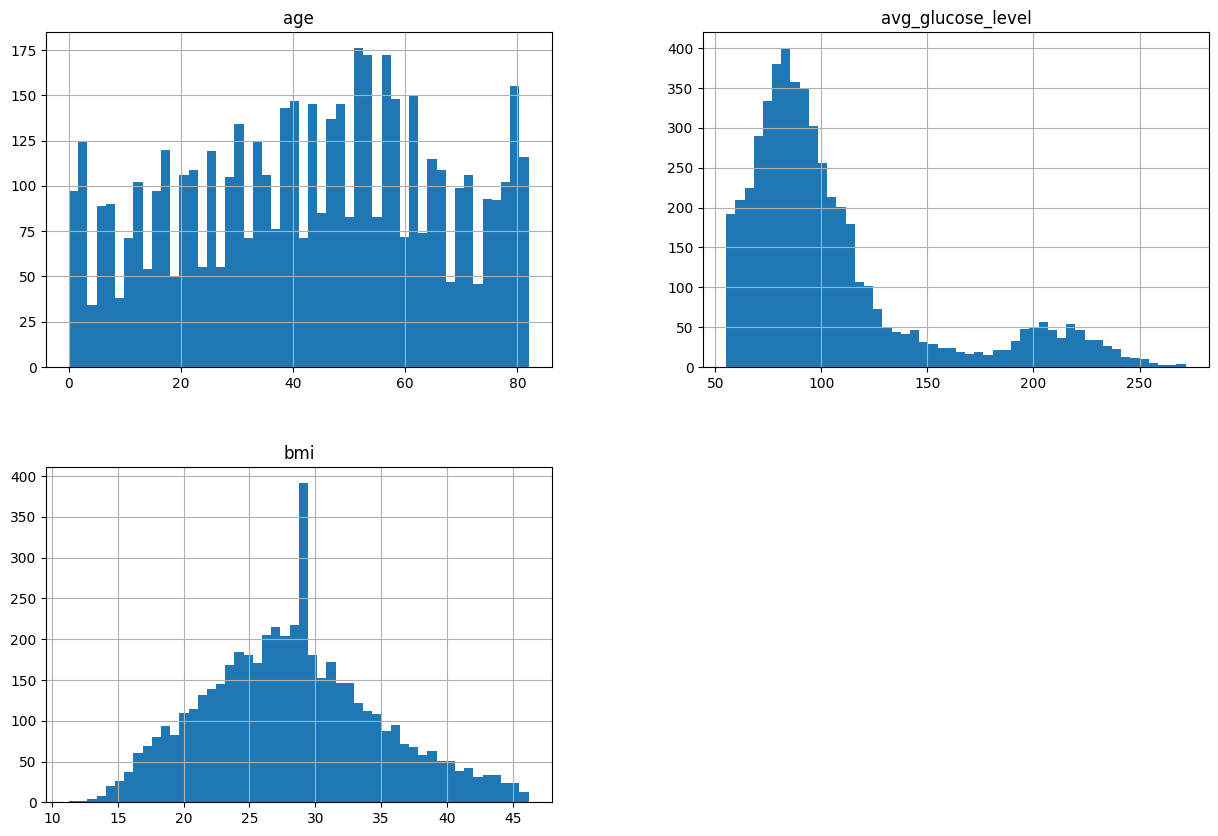

In [26]:
# Menampilkan histogram pada masing-masing numerical features
stroke_data[numeric_features].hist(bins=50, figsize=(15, 10))

plt.show()

# **EDA - Multivariate Analysis**

## **Categorical Features**

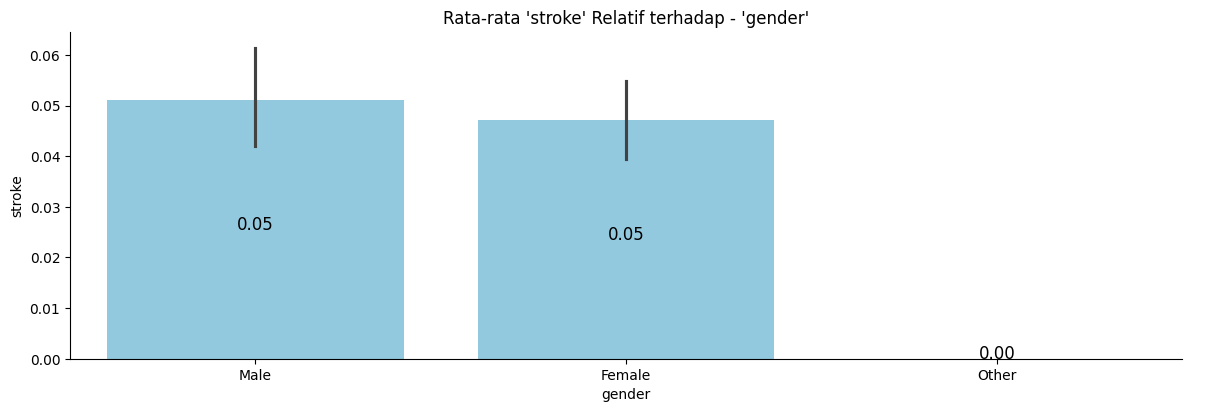

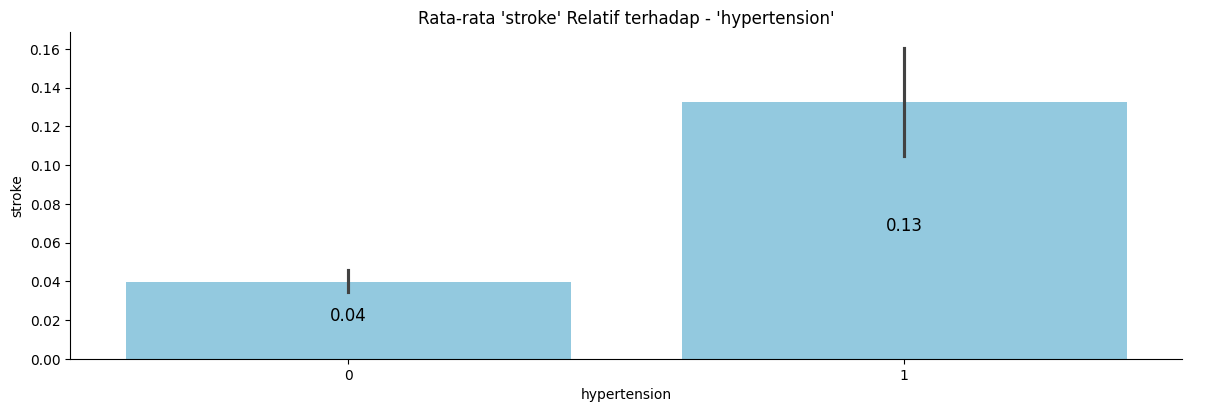

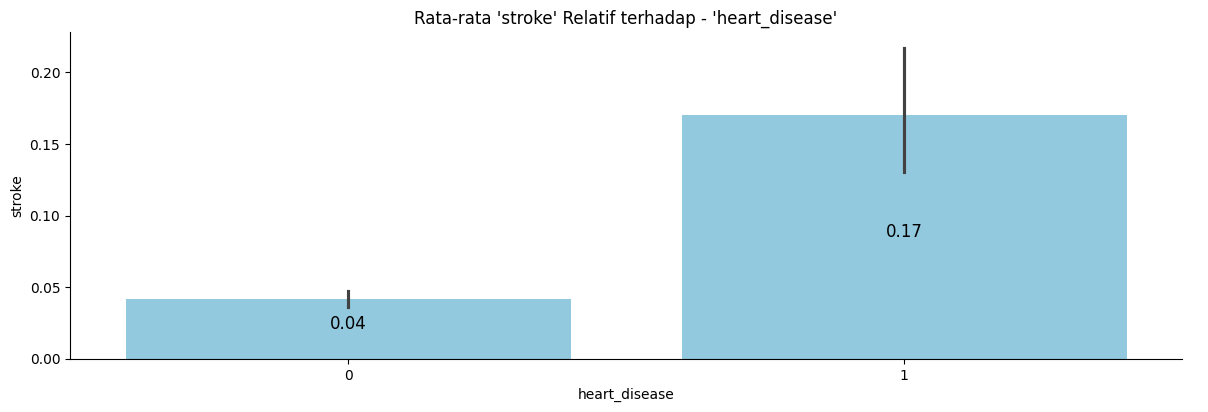

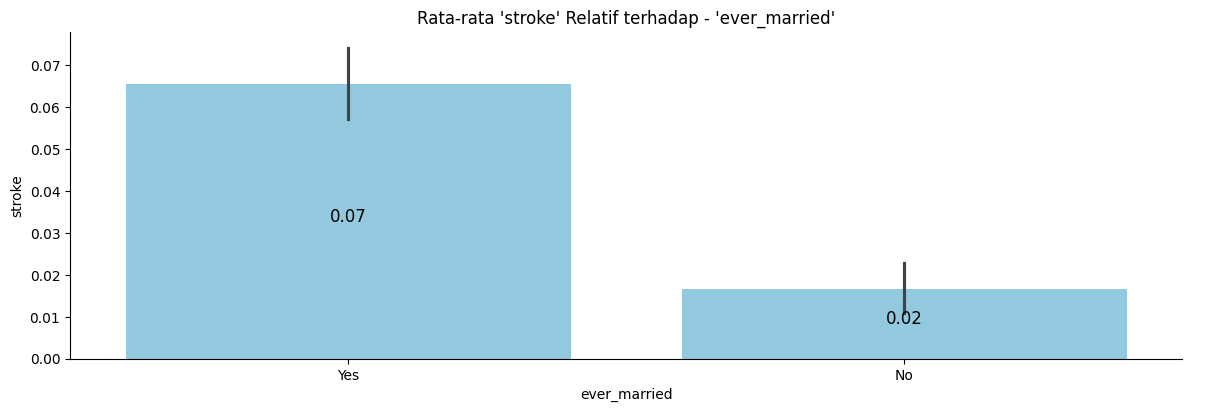

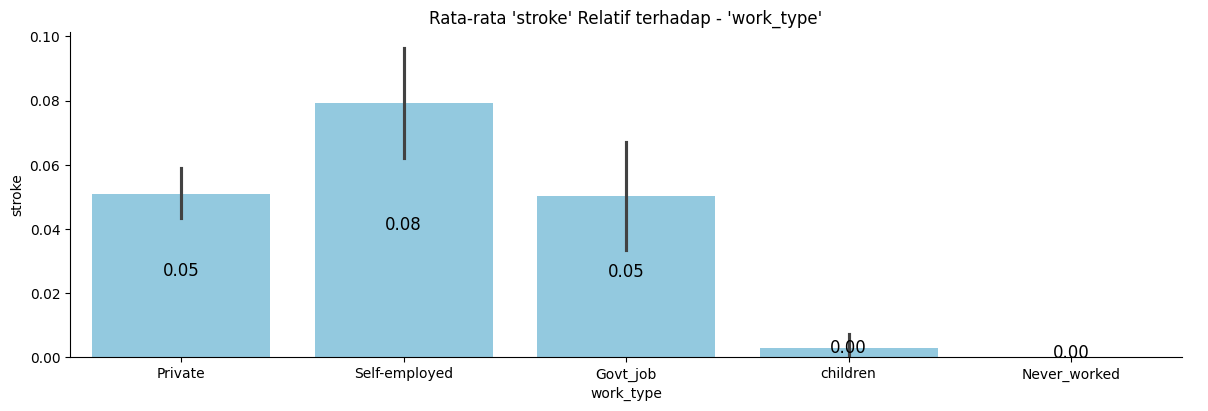

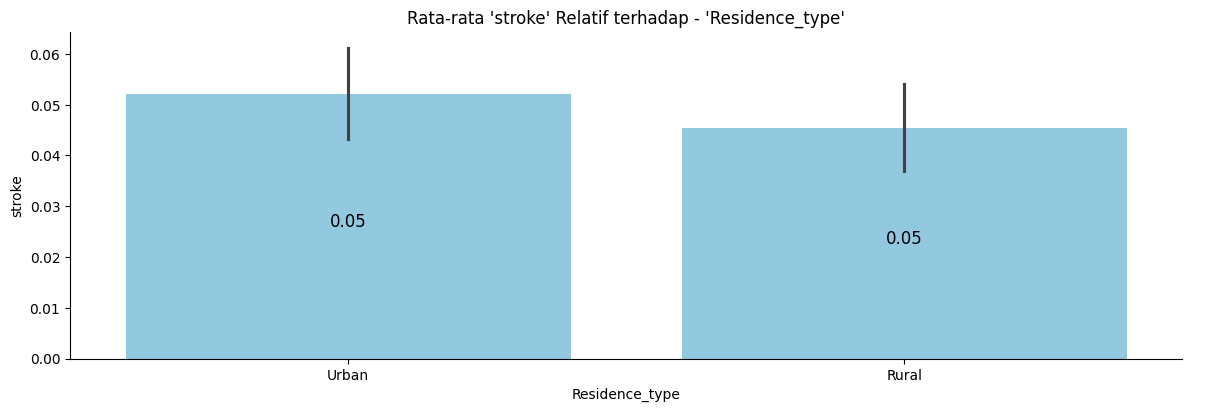

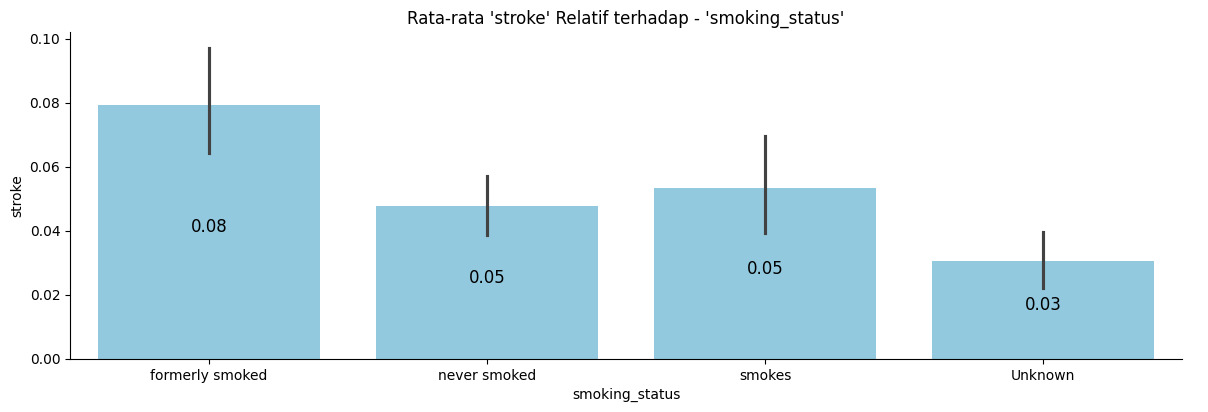

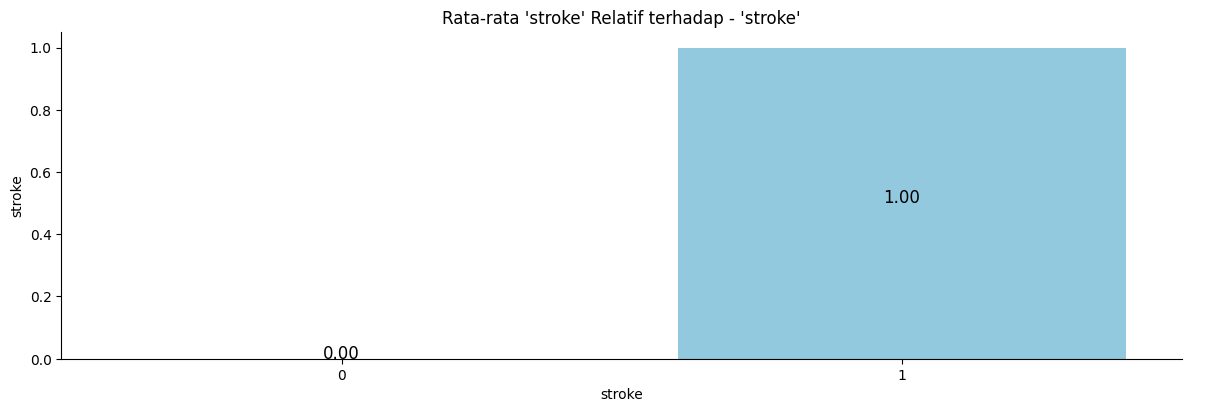

In [27]:
# Mengecek rata-rata 'stroke' terhadap masing-masing fitur
cat_features = stroke_data[categoric_features].columns.to_list()

for col in cat_features:
    catplot = sns.catplot(x=col, y='stroke', kind='bar', dodge=False, height=4, aspect=3, data=stroke_data, color='skyblue')
    plt.title("Rata-rata 'stroke' Relatif terhadap - '{}'".format(col))

    # Menambahkan label nilai pada setiap bar
    ax = catplot.ax
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height()/2, '{0:.2f}'.format(p.get_height()),
                fontsize=12, color='black', ha='center')

    plt.show()

## **Numerical Features**

Menampilkan kolerasi antar fitur numerik.

Text(0.5, 1.0, '   Correlation Matrix untuk Fitur Numerik\n')

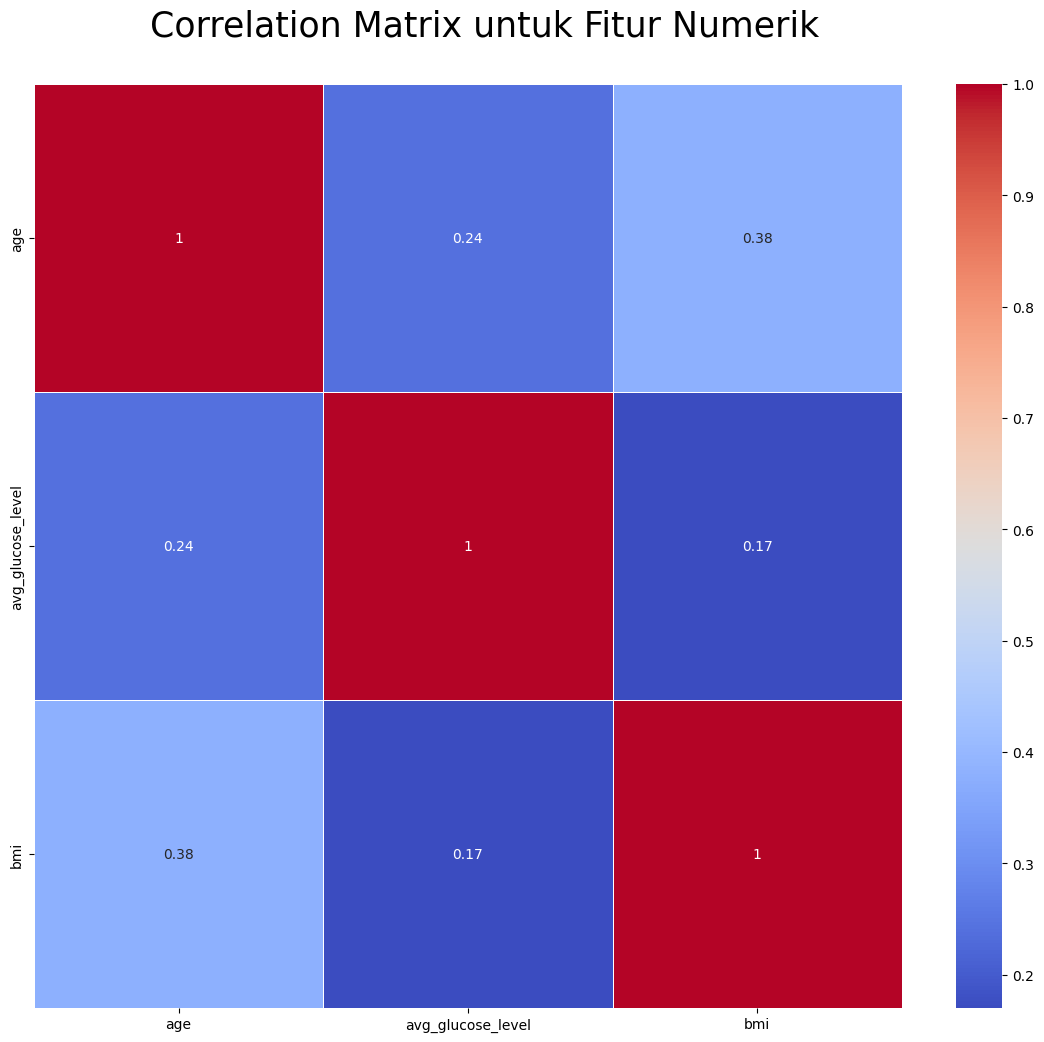

In [28]:
# Mengevaluasi skor korelasi
plt.figure(figsize=(14, 12))
correlation_matrix = stroke_data[numeric_features].corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title('   Correlation Matrix untuk Fitur Numerik\n', size=25)

# **Data Preparation**

Fitur "id" akan dihapus karena tidak dibuthkan dalam membuat sistem prediksi stroke.

In [29]:
stroke_data.drop(['id'], axis=1, inplace=True)

stroke_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


Menangani missing value setelah penanganan outliers.

In [30]:
# Mengecek missing value pada dataset
stroke_data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  126
smoking_status         0
stroke                 0
dtype: int64

Dari output diata didapatkan ada missing value setelah penanganan outliers pada fitur 'bmi'. Maka dari itu dilakukan penanganan dengan mengganti missing value tersebut dengan nilai rata-rata BMI.

In [31]:
# Menangani missing value
stroke_data['bmi'].fillna(stroke_data['bmi'].mean(), inplace=True)

Pada tahap Exploratory Data Analysis - Univariate Analysis terhadap Categorical Features didapatkan sampel 'Other' pada fitur 'gender' memiliki terlalu sedikit sampel. Maka akan dilakukan penghapusan terhadap sampel ini.

In [32]:
# Menghapus sample 'Other' pada fitur 'gender'
stroke_data.drop(stroke_data[(stroke_data['gender'] == 'Other')].index, inplace=True)

## **Encoding Categorical Features**
Pada tahap ini fitur kategori bertipe object akan diubah menjadi fitur numerik dengan menggunakan Label Encoder. Hal ini bertujuan untuk mengubah label kategori menjadi bilangan bulat agar dapat dimengerti oleh algoritma pembelajaran mesin atau model.

In [33]:
stroke_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [34]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [35]:
labelEnc = LabelEncoder()

gender = labelEnc.fit_transform(stroke_data['gender'])
ever_married = labelEnc.fit_transform(stroke_data['ever_married'])
work_type = labelEnc.fit_transform(stroke_data['work_type'])
Residence_type = labelEnc.fit_transform(stroke_data['Residence_type'])
smoking_status = labelEnc.fit_transform(stroke_data['smoking_status'])

In [36]:
stroke_data['gender']=gender
stroke_data['ever_married']=ever_married
stroke_data['work_type']=work_type
stroke_data['Residence_type']=Residence_type
stroke_data['smoking_status']=smoking_status

stroke_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.600000,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.600000,1,0


Dari output diatas dapat diketahui label kategori telah berubah menjadi bilangan bulat.

## **Mengatasi Data yang Tidak Seimbang**
Pada tahap Exploratory Data Analaysis - Univariate Analysis terhadap Numerical Features, diketahui pada fitur terget 'stroke' memiliki data yang tidak seimbang.

   Jumlah Sampel  Persentase
0           4860        95.1
1            249         4.9


Text(0.5, 1.0, 'stroke')

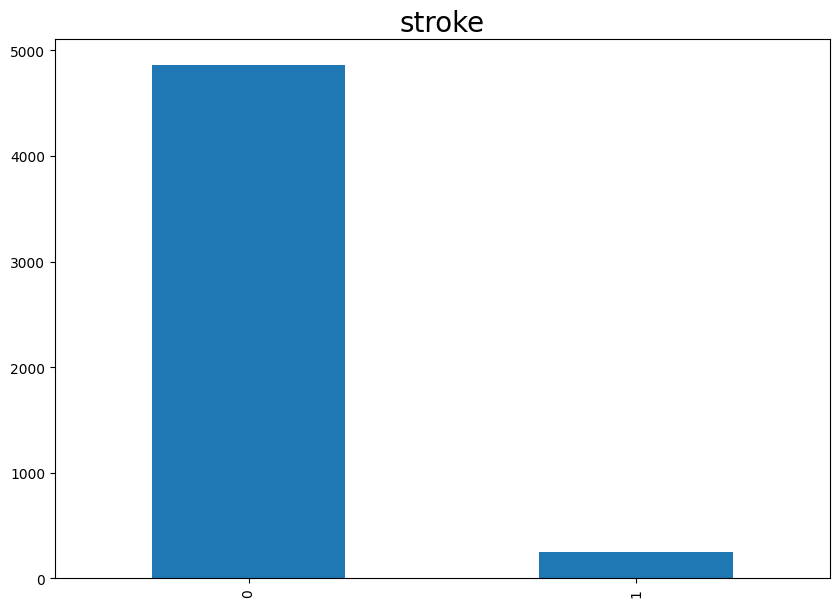

In [37]:
# Memvisualisasikan categorical features 'stroke'
plt.figure(figsize=(10, 7))
feature = categoric_features[7]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

Maka hal ini akan ditangani dengan teknik oversampling menggunakan SMOTE.
SMOTE merupakan salah satu pendekatan untuk mengatasi kumpulan data yang tidak seimbang dengan mengambil sample kelas minoritas secara berlebihan. Pendekatan paling sederhana melibatkan duplikasi contoh di kelas minoritas, meskipun contoh ini tidak menambahkan informasi baru ke model. Sebaliknya, contoh baru dapat disintesis dari contoh yang sudah ada. Ini adalah jenis augmentasi data untuk kelas minoritas dan disebut sebagai Synthetic Minority Oversampling Technique, atau disingkat SMOTE.

In [38]:
X = stroke_data.loc[:, stroke_data.columns != 'stroke']
y = stroke_data['stroke']

smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=78)

X_smote, y_smote = smote.fit_resample(X, y)

stroke_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)

   Jumlah Sampel  Persentase
1           4860        50.0
0           4860        50.0


Text(0.5, 1.0, 'stroke')

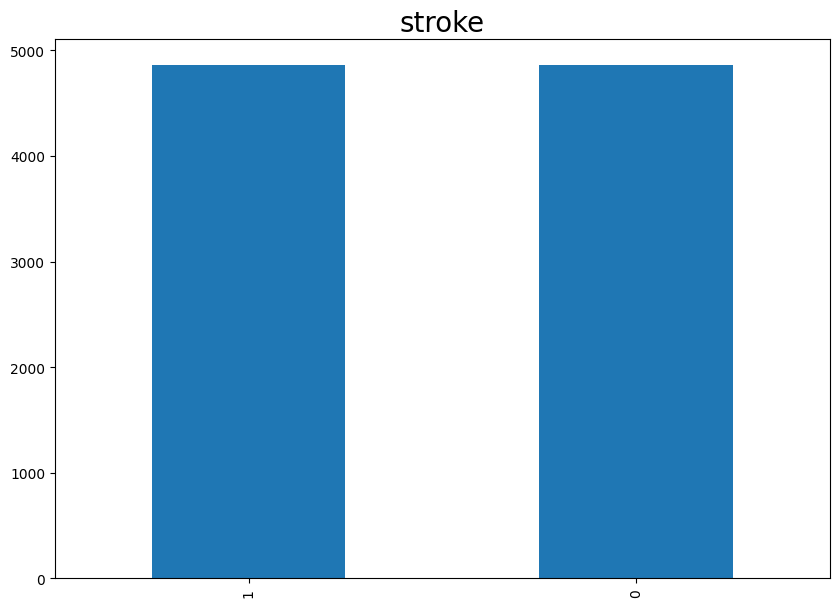

In [39]:
# Memvisualisasikan categorical features "stroke"
plt.figure(figsize=(10, 7))
feature = categoric_features[7]
count = stroke_data[feature].value_counts()
percent = 100 * stroke_data[feature].value_counts(normalize=True)
df = pd.DataFrame({'Jumlah Sampel':count, 'Persentase':percent.round(1)})

print(df)
count.plot(kind='bar');
plt.title(feature, size=20)

## **Train-Test-Split**
Melakukan pembagian dataset menjadi data latih (train) dan data uji (test) dengan mempertahankan sebagian data yang ada untuk menguji seberapa baik generalisasi model terhadap data baru. Pembagian data dilakukan sebelum proses transformasi data, sehingga dapat mengurangi potensi kebocoran data (data leakage). Pembagian dataset dilakukan dengan proporsi pembagian sebesar 80:20.

In [40]:
# Membagi dataset menjadi data latih (train) dan data uji (test)
X = stroke_data.drop(['stroke'], axis=1)
y = stroke_data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Mengecek jumlah sample pada masing-masing bagian
print(f'Total # of sample in whole dataset : {len(X)}')
print(f'Total # of sample in train dataset : {len(X_train)}')
print(f'Total # of sample in test dataset  : {len(X_test)}')

Total # of sample in whole dataset : 9720
Total # of sample in train dataset : 7776
Total # of sample in test dataset  : 1944


## **Standarisasi**
Digunakan StandardScaler dalam melakukan proses standarisasi fitur dengan mengurangkan mean (nilai rata-rata) kemudian membaginya dengan standar deviasi untuk menggeser distribusi.  StandardScaler menghasilkan distribusi dengan standar deviasi sama dengan 1 dan mean sama dengan 0.

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Menyimpan Scaler Object**
Scaler object disimpan dalam format pickle untuk nantinya digunakan dalam melakukan proses deployment.

In [42]:
!mkdir ML-Models

In [43]:
# Menyimpan scaler object
scaler_path = os.path.join('/content/ML-Models/scaler.pkl')
with open(scaler_path, 'wb') as scaler_file:
  pickle.dump(scaler, scaler_file)

# **Model Development**
Dalam mengembangkan model Machine Learning pada proyek ini digunakan 3 algoritma, yang kemudian akan dievaluasi performa dari masing-masing algoritma dan menentukan salah satu algoritma yang memberikan hasil prediksi terbaik.

Pada tahap ini hanya melatih data training dan menyimpan data testing untuk tahap Evaluasi Model.

In [44]:
# Menyiapkan dataframe untuk analisis menggunakan 3 model algoritma
models = pd.DataFrame(index=['train_f1', 'test_f1'],
                      columns=['K-Nearest Neighbor', 'Decision Tree', 'Random Forest'])

## **Model Development dengan K-Nearest Neighbor**
KNN bekerja dengan membandingkan jarak satu sampel ke sampel pelatihan lain dengan memilih sejumlah k tetangga terdekat (dengan k adalah sebuah angka positif).

In [45]:
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
knn.fit(X_train, y_train)

models.loc['train_f1', 'knn'] = f1_score(y_pred = knn.predict(X_train), y_true=y_train)

print('Train Score :', knn.score(X_train, y_train))
print('Test Score  :', knn.score(X_test, y_test))

Train Score : 0.9835390946502057
Test Score  : 0.9516460905349794


- n_neighbors: jumlah tetangga terdekat yang digunakan untuk menentukan label kelas dari suatu sampel.

- metric: metrik jarak yang digunakan untuk mengukur jarak antara sampel-sampel.

Sehingga didapatkan Train Score sebesar 98%, dan Test Score sebesar 95%.

## **Model Development dengan Decision Tree**

Decision Tree (Pohon Keputusan) bekerja dengan membuat serangkaian keputusan berbasis fitur-fitur pada dataset. Proses pembuatan keputusan dimulai dari akar pohon dan berlanjut ke cabang-cabang hingga mencapai daun (leaf). Setiap node pada pohon keputusan mewakili keputusan atau tes berdasarkan nilai fitur tertentu.

In [46]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=17, min_samples_leaf=2, min_samples_split=7)
dt.fit(X_train, y_train)

models.loc['train_f1', 'dt'] = f1_score(y_pred = dt.predict(X_train), y_true=y_train)

print('Train Score :', dt.score(X_train, y_train))
print('Test Score  :', dt.score(X_test, y_test))

Train Score : 0.9822530864197531
Test Score  : 0.9284979423868313


- criterion: untuk mengukur kualitas split. 'entropy' (entropi) digunakan untuk mengukur ketidakmurnian (impurity) dalam node pohon.

- max_depth: menentukan kedalaman maksimum dari pohon.

- min_samples_leaf: menentukan seberapa banyak sampel minimal yang dibutuhkan di akhir setiap cabang pohon.

- min_samples_split: menentukan seberapa banyak sampel minimal yang dibutuhkan agar node internal melakukan split atau pembelahan.

Sehingga didapatkan Train Score sebesar 98%, dan Test Score sebesar 93%.

## **Model Development dengan Random Forest**
Random Forest bekerja dengan membangun beberapa pohon keputusan (decision tree) selama pelatihan dan menggabungkan hasil prediksi dari pohon-pohon tersebut untuk mendapatkan prediksi yang lebih akurat dan stabil.

In [47]:
rf = RandomForestClassifier(n_estimators=32, max_depth=32, random_state=55, n_jobs=-1)
rf.fit(X_train, y_train)

models.loc['train_f1', 'rf'] = f1_score(y_pred = rf.predict(X_train), y_true=y_train)

print('Train Score :', rf.score(X_train, y_train))
print('Test Score  :', rf.score(X_test, y_test))

Train Score : 0.9998713991769548
Test Score  : 0.963477366255144


- n_estimator: jumlah trees (pohon) di forest.
- max_depth: kedalaman atau panjang pohon.
- random_state: digunakan untuk mengontrol random number generator yang digunakan.
- n_jobs: jumlah job (pekerjaan) yang digunakan secara paralel. n_jobs = -1 artinya semua proses berjalan secara paralel.

Sehingga didapatkan Train Score sebesar 99%, dan Test Score sebesar 96%.

# **Evaluasi Model**
Metrik evaluasi yang digunakan pada prediksi stroke ini adalah F1 score yang mengukur seimbang antara presisi (precision) dan recall pada suatu model klasifikasi.

In [48]:
# Buat variabel f1 yang isinya adalah dataframe nilai F1 score pada data train dan test pada masing-masing algoritma
f1 = pd.DataFrame(columns=['train', 'test'], index=['K-Nearest Neighbor', 'Decision Tree', 'Random Forest'])

# Buat dictionary untuk setiap algoritma yang digunakan
model_dict = {'K-Nearest Neighbor': knn, 'Decision Tree': dt, 'Random Forest': rf}

# Hitung F1 score masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
    f1.loc[name, 'train'] = f1_score(y_true=y_train, y_pred=model.predict(X_train), average='micro')
    f1.loc[name, 'test'] = f1_score(y_true=y_test, y_pred=model.predict(X_test), average='micro')

# Panggil nilai F1 score
f1

,train,test
K-Nearest Neighbor,0.983539,0.951646
Decision Tree,0.982253,0.928498
Random Forest,0.999871,0.963477


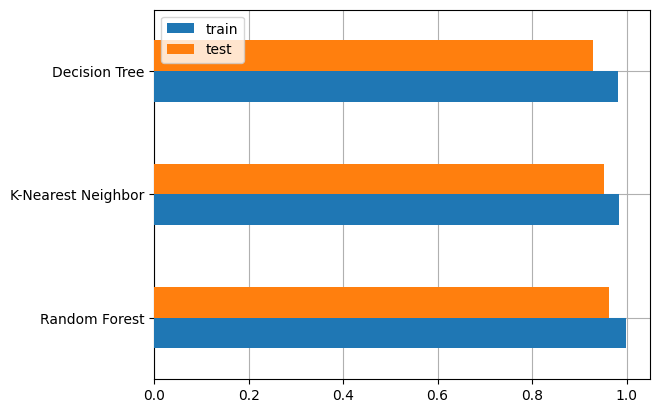

In [49]:
# Menampilkan plot
fig, ax = plt.subplots()
f1.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)
plt.legend(loc=2)

Dari output diatas, dapat diketahui bahwa model development dengan algoritma Random Forest memiliki performa terbaik dengan nilai Train Score sebesar 99% dan Test Score sebesar 96%. Maka algoritma inilah yang akan digunakan untuk deployment untuk melakukan prediksi.

# **Menyimpan Model dengan Akurasi Terbaik**
Algoritma Random Forest yang merupakan algoritma dengan performa terbaik disimpan dalam format pickle untuk nantinya digunakan dalam proses deployment dan melakukan prediksi.

In [50]:
pickle.dump(rf, open('/content/ML-Models/model.pkl', 'wb'))